In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mpld3
from mpld3 import plugins
import os
from datetime import datetime,date,timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go


/Users/noma/OneDrive_UTA/OneDrive - UT Arlington/mac/WorkSpace/FG-CRYPTO/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def get_fear_greed_data(limit=30):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json&date_format=us"
    response = requests.get(url)
    data = response.json()["data"]
    # Convert the data into a DataFrame
    fear_greed_df = pd.DataFrame(data)
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp']).dt.date
    fear_greed_df['value'] = fear_greed_df['value'].astype(int)
    return fear_greed_df[['date','value_classification' ,'value']]

In [3]:
def get_real_time_price(symbol, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD"
    headers = {
        "X-CoinAPI-Key": api_key
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    
    if 'rate' in data:
        return data['rate']
    else:
        print(f"Error fetching real-time price: {data}")
        return None

def get_historical_price_data(symbol, start_date, end_date, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD/history"
    
    headers = {
        "X-CoinAPI-Key": api_key
    }
    
    params = {
        "period_id": "1DAY",
        "time_start": start_date.isoformat(),
        "time_end": end_date.isoformat(),
        "limit": 10000
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    if not isinstance(data, list) or len(data) == 0:
        print(f"Unexpected API response: {data}")
        return pd.DataFrame(columns=['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price'])
    
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['time_period_start']).dt.date
    df = df.rename(columns={'rate_open': 'daily_min_price', 'rate_high': 'daily_max_price', 'rate_close': 'daily_avg_price'})
    df = df[['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price']]

    # print(df.head())

    rt_price = get_real_time_price(symbol, api_key)
    rt_df = pd.DataFrame({
    'date': [pd.to_datetime('now').date()],  # Use current date
    'daily_avg_price': [rt_price],    # Use the real-time price
    'daily_min_price': [rt_price],     # Assuming min and max are the same for real-time
    'daily_max_price': [rt_price]
    })

    # print(rt_df.head())

    # Join the real-time price DataFrame with historical
    df = pd.concat([df, rt_df], ignore_index=True)

    # Optionally, sort the DataFrame by date
    df.sort_values('date', ascending=True, inplace=True)

    # generate utility columns

    # Initialize current max price
    current_max_price = 0
    # List to store the price ratios
    price_ratios = []
    max_prices = []

    # Calculate price ratios
    for index, row in df.iterrows():
        daily_avg_price = row['daily_avg_price']
        
        # Update current max price
        current_max_price = max(current_max_price, daily_avg_price)      
        # Calculate the ratio
        price_ratio = (daily_avg_price - current_max_price) / current_max_price
        price_ratios.append(price_ratio)
        max_prices.append(current_max_price)
    # Add the price ratios to the DataFrame
    df['price_ratio'] = price_ratios
    df['current_max_price'] = max_prices  # Add current max price as a new column

 
    
    df['MA_30'] = df['daily_avg_price'].rolling(window=30).mean()
    df['MA_60'] = df['daily_avg_price'].rolling(window=60).mean()
    df['MA_90'] = df['daily_avg_price'].rolling(window=90).mean()
    df['MA_120'] = df['daily_avg_price'].rolling(window=120).mean()
    df['MA_150'] = df['daily_avg_price'].rolling(window=150).mean()
    df['MA_180'] = df['daily_avg_price'].rolling(window=180).mean()
    # df['MA125_ratio'] = (df['MA_125']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA30_ratio'] = (df['MA_30']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA60_ratio'] = (df['MA_60'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA90_ratio'] = (df['MA_90'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA120_ratio'] = (df['MA_120'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA150_ratio'] = (df['MA_150'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA180_ratio'] = (df['MA_180'] - df['daily_avg_price']) / df['daily_avg_price']
    return df[['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price','current_max_price','price_ratio','MA_30','MA_60','MA_90','MA_120','MA_150','MA_180', \
    'MA30_ratio', 'MA60_ratio','MA90_ratio','MA120_ratio','MA150_ratio','MA180_ratio']]



# Replace with your actual CoinAPI key
#api_key = os.environ.get("COINAPI_KEY")
api_key = 'ed623c1a-2318-496b-9511-1ebeabd536f0'

def get_price_data(symbol,days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    return get_historical_price_data(symbol, start_date, end_date, api_key)

In [4]:
bitcoin_df = get_price_data("BTC", 365*6)
bitcoin_df.sort_values('date',ascending=True).head(100)

Unexpected API response: {'title': 'Forbidden', 'status': 429, 'detail': 'Quota exceeded: Insufficient Usage Credits.', 'error': 'Forbidden (Quota exceeded: Insufficient Usage Credits.)', 'QuotaKey': 'BA', 'QuotaName': 'Insufficient Usage Credits', 'QuotaType': 'Organization Limit', 'QuotaValueCurrentUsage': 1451, 'QuotaValue': 1448, 'QuotaValueUnit': '$', 'QuotaValueAdjustable': 'Yes, upgrade subscription, add service credits manually or setup auto-recharge.'}


,date,daily_min_price,daily_max_price,daily_avg_price


In [234]:
fear_greed_df = get_fear_greed_data(365*6) 
fear_greed_df 

,date,value_classification,value
0,2024-11-02,Greed,72
1,2024-11-01,Greed,75
2,2024-10-31,Extreme Greed,77
3,2024-10-30,Extreme Greed,77
4,2024-10-29,Greed,72
...,...,...,...
2185,2018-11-08,Neutral,51
2186,2018-11-07,Neutral,48
2187,2018-11-06,Fear,42
2188,2018-11-05,Fear,42


In [235]:
def merge_data(fear_greed_df, coin_df):
    # Merge the two DataFrames on the 'timestamp' column
    merged_df = pd.merge(fear_greed_df, coin_df, on='date', how='inner')
    return merged_df

In [240]:
merged_bitcoin_fg_df = merge_data(bitcoin_df, fear_greed_df)
merged_bitcoin_fg_df.sort_values('date',ascending=False).head(100)

,date,daily_min_price,daily_max_price,daily_avg_price,current_max_price,price_ratio,MA_30,MA_60,MA_90,MA_120,MA_150,MA_180,MA30_ratio,MA60_ratio,MA90_ratio,MA120_ratio,MA150_ratio,MA180_ratio,value_classification,value
2188,2024-11-01,69522.592634,69522.592634,69522.592634,73118.101072,-0.049174,66035.859112,63279.884650,62034.331426,62296.782728,62798.162840,63386.440529,-0.050153,-0.089794,-0.107710,-0.103935,-0.096723,-0.088261,Greed,75
2187,2024-10-31,72322.670656,72675.265967,70198.752534,73118.101072,-0.039926,65739.537002,63106.702192,61935.803423,62192.264029,62805.061461,63355.886617,-0.063523,-0.101028,-0.117708,-0.114055,-0.105325,-0.097478,Extreme Greed,77
2186,2024-10-30,72715.810794,72937.046925,72322.212507,73118.101072,-0.010885,65426.127244,62891.807842,61837.653476,62108.648304,62795.778504,63320.892128,-0.095352,-0.130394,-0.144970,-0.141223,-0.131722,-0.124461,Extreme Greed,77
2185,2024-10-29,69940.512845,73606.783325,72715.810794,73118.101072,-0.005502,65125.988271,62669.192007,61760.610964,62022.879905,62765.293283,63268.600278,-0.104377,-0.138163,-0.150658,-0.147051,-0.136841,-0.129920,Greed,72
2184,2024-10-28,67938.251373,70226.163701,69918.139972,73118.101072,-0.043764,64889.146019,62442.422400,61670.578836,61940.707436,62731.976960,63192.773558,-0.071927,-0.106921,-0.117960,-0.114097,-0.102780,-0.096189,Greed,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,2024-07-28,67902.227749,68292.589995,68271.205074,73118.101072,-0.066289,62437.227369,64371.002572,64558.148856,64979.237629,65498.033267,62853.173169,-0.085453,-0.057128,-0.054387,-0.048219,-0.040620,-0.079360,Greed,71
2092,2024-07-27,67917.972656,69411.207463,68038.605855,73118.101072,-0.069470,62171.971885,64359.199858,64508.968070,64990.445502,65450.706330,62712.458702,-0.086225,-0.054078,-0.051877,-0.044800,-0.038036,-0.078281,Greed,72
2091,2024-07-26,65786.333383,68209.529081,67910.052986,73118.101072,-0.071228,61957.796239,64364.029660,64454.063264,65005.901506,65413.801952,62575.030799,-0.087649,-0.052216,-0.050891,-0.042765,-0.036758,-0.078560,Greed,68
2090,2024-07-25,65363.911293,66152.528231,65782.813751,73118.101072,-0.100321,61721.176631,64388.452634,64404.113483,65029.891562,65341.513630,62431.247639,-0.061743,-0.021196,-0.020958,-0.011446,-0.006708,-0.050949,Greed,68


In [140]:
def plot_data_with_fear_greed_alerts(merged_df, symbol, buy_points=None):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['daily_avg_price'], 
            name=f"{symbol} Price", 
            line=dict(color='blue'),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Price:</b> $%{y:.2f}<br>' +
                          '<b>Sentiment:</b> %{text}<br>',
            text=merged_df['value']  # Add sentiment to hover text
        ),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['value'], 
            name="Fear & Greed Index", 
            line=dict(color='black', width=2),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Fear & Greed Index:</b> %{y}<br>',
        ),
        secondary_y=True,
    )

    # Add moving averages
    moving_averages = ['MA_120']
    colors = ['purple']  # Different colors for each MA

    for ma, color in zip(moving_averages, colors):
        if ma in merged_df.columns:
            fig.add_trace(
                go.Scatter(
                    x=merged_df['date'],
                    y=merged_df[ma],
                    name=ma,
                    line=dict(color=color, width=2, dash='dash')
                )
            )

    # Add MA120_ratio
    # fig.add_trace(
    #     go.Scatter(x=merged_df['date'], y=merged_df['MA120_ratio'], name="MA120_ratio", line=dict(color='yellow', width=2, dash='dash')),
    #     secondary_y=False,
    # )

    # Add colored background for different index ranges
    # fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_avg_price'].min() * 0.8, merged_df['daily_avg_price'].max() * 1.2], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    if buy_points is not None and not buy_points.empty:
        fig.add_trace(
            go.Scatter(
                x=buy_points['date'],
                y=buy_points['daily_avg_price'],
                mode='markers',
                name='Buy Points',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                hovertemplate='<b>Buy Date:</b> %{x|%Y-%m-%d}<br>' +
                                '<b>Price:</b> $%{y:.2f}<br>'
            )
        )

    return fig

In [237]:
plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df,'BTC')

In [242]:
def trading_strategy(symbol,df,investment_amount,strategy):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    total_investment = 0
    trades = []
    # df['MA'] = df['daily_avg_price'].rolling(window=60).mean()
    trades_records = []
    last_investment_month = None
    
    
    for index, row in df.iterrows():
        
        date = row['date']
        daily_avg_price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        MA120 = row['MA_120']
        MA120_ratio = row['MA120_ratio']
        price_ratio = row['price_ratio']
        #ma = row['MA']
        # Get the current month and year
        current_max_price = row['current_max_price']
        current_month = date.month
        current_year = date.year

        if strategy == 'Only buy when sentiment is Extreme Fear':

            if sentiment == 'Extreme Fear':
                # Buy Bitcoin
                usd_balance = investment_amount 
                # if index < 20:
                #     usd_balance += 500
                    
                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })
        elif strategy == 'Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6':
            if sentiment == 'Extreme Fear':
                usd_balance = investment_amount 
                if (index < 20  and MA120_ratio >= 0.6):
                # Buy Bitcoin
                    usd_balance += 1000

                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, MA120: {MA120:.2f}, MA120_ratio : {MA120_ratio:.2f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })

        elif strategy == 'Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6 and buy even more if price_ratio < 0.7':
            if sentiment == 'Extreme Fear':
                usd_balance = investment_amount 
                if (index < 20  and MA120_ratio >= 0.6) or (price_ratio <= -0.7):
                # Buy Bitcoin
                    usd_balance += 1000
                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, MA120: {MA120:.2f}, MA120_ratio : {MA120_ratio:.2f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })
        elif strategy == 'Buy every month at month start and buy more when extreme fear and M120_ratio >= 0.6':
            if (last_investment_month is None) or (current_month != last_investment_month or current_year != last_investment_year):
            # Buy $1000 at the start of the month
                usd_balance = investment_amount
                if (index < 20  and MA120_ratio >= 0.6):
                    usd_balance += 2000
                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, MA120: {MA120:.2f}, MA120_ratio: {MA120_ratio:.2f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                
                # Update the last investment month
                last_investment_month = current_month
                last_investment_year = current_year
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })
        elif strategy == 'Only Buy when index <= 20 and MA120_ratio >= 0.6':
            if (index <= 20 and MA120_ratio >= 0.6):
            # Buy Bitcoin
                usd_balance = investment_amount + 2000
                # if price < ma125_price * 0.8:
                #     usd_balance += 500
                
                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, MA120: {MA120:.2f}, MA120_ratio : {MA120_ratio:.2f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })

        elif strategy == 'Only Buy when index <= 20':
            if (index <= 20):
            # Buy Bitcoin
                usd_balance = investment_amount + 2000
                # if price < ma125_price * 0.8:
                #     usd_balance += 500
                
                to_buy = usd_balance / daily_avg_price
                held += to_buy
                trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${daily_avg_price:.2f}, Current Max Price: {current_max_price:.2f}, Price Ratio: {price_ratio:.2f}, {symbol}: {to_buy:.6f}, MA120: {MA120:.2f}, MA120_ratio : {MA120_ratio:.2f}, Sentiment: {index}, {sentiment}")
                total_investment += usd_balance
                trades_records.append({
                    'date': date,
                    'action': 'Buy',
                    'amount_invested': usd_balance,
                    'daily_avg_price': daily_avg_price,
                    'symbol': symbol,
                    'quantity': to_buy,
                    'sentiment': sentiment
                })

    # Calculate final portfolio value
    final_value = (held * df.iloc[-1]['daily_avg_price'])
    trades_df = pd.DataFrame(trades_records)

    return trades, held,final_value,total_investment, trades_df

# Run the strategy
symbol = "BTC"
investment_amount = 500

strategy_list = ['Only buy when sentiment is Extreme Fear', \
                 'Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6', \
                    'Buy every month at month start and buy more when extreme fear and M120_ratio >= 0.6', \
                        'Only Buy when index <= 20 and MA120_ratio >= 0.6', \
                            'Only Buy when index <= 20', \
                                'Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6 and buy even more if price_ratio < 0.7']

start_date = '2020-01-01'
dataset =  merged_bitcoin_fg_df[merged_bitcoin_fg_df['date'] >= pd.to_datetime(start_date).date()]

for strategy in strategy_list:
    trades, held,final_value,total_investment, trades_df = trading_strategy(symbol,dataset,investment_amount,strategy)

# Print results
    print(f"{symbol} {strategy}: start date {start_date}")
    print(f"Number of trades: {len(trades)}")
    print(f"Bought: {held:.6f} {symbol}")
    print(f"Each investment: ${investment_amount:.2f}")
    print(f"Total investment: ${total_investment:.2f}")
    print(f"Final portfolio value: ${final_value:.2f}")
    print(f"Profit: ${final_value - total_investment:.2f}")
    annualized_return = ((final_value / total_investment) ** (365 / len(dataset))) - 1
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print("\nTrade History:")
    for trade in trades:
        print(trade)
    fig = plot_data_with_fear_greed_alerts(dataset, "BTC",trades_df)
    fig.show()




BTC Only buy when sentiment is Extreme Fear: start date 2020-01-01
Number of trades: 339
Bought: 9.049689 BTC
Each investment: $500.00
Total investment: $169500.00
Final portfolio value: $629157.81
Profit: $459657.81
Annualized Return: 31.14%

Trade History:
Buy: 2020-03-09, usd_balance: $500.00, Price: $7953.21, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062868, Sentiment: 17, Extreme Fear
Buy: 2020-03-10, usd_balance: $500.00, Price: $7910.87, Current Max Price: 12925.48, Price Ratio: -0.39, BTC: 0.063204, Sentiment: 16, Extreme Fear
Buy: 2020-03-11, usd_balance: $500.00, Price: $7952.50, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062873, Sentiment: 17, Extreme Fear
Buy: 2020-03-12, usd_balance: $500.00, Price: $4856.40, Current Max Price: 12925.48, Price Ratio: -0.62, BTC: 0.102957, Sentiment: 14, Extreme Fear
Buy: 2020-03-13, usd_balance: $500.00, Price: $5622.30, Current Max Price: 12925.48, Price Ratio: -0.57, BTC: 0.088932, Sentiment: 10, Extreme Fear
B

BTC Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6: start date 2020-01-01
Number of trades: 339
Bought: 10.725453 BTC
Each investment: $500.00
Total investment: $197500.00
Final portfolio value: $745661.32
Profit: $548161.32
Annualized Return: 31.60%

Trade History:
Buy: 2020-03-09, usd_balance: $500.00, Price: $7953.21, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062868, MA120: 8342.86, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-10, usd_balance: $500.00, Price: $7910.87, Current Max Price: 12925.48, Price Ratio: -0.39, BTC: 0.063204, MA120: 8336.01, MA120_ratio : 0.05, Sentiment: 16, Extreme Fear
Buy: 2020-03-11, usd_balance: $500.00, Price: $7952.50, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062873, MA120: 8328.78, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-12, usd_balance: $1500.00, Price: $4856.40, Current Max Price: 12925.48, Price Ratio: -0.62, BTC: 0.308871, MA120: 8296.22, MA

BTC Buy every month at month start and buy more when extreme fear and M120_ratio >= 0.6: start date 2020-01-01
Number of trades: 59
Bought: 1.397958 BTC
Each investment: $500.00
Total investment: $31500.00
Final portfolio value: $97189.67
Profit: $65689.67
Annualized Return: 26.22%

Trade History:
Buy: 2020-01-01, usd_balance: $500.00, Price: $7204.93, Current Max Price: 12925.48, Price Ratio: -0.44, BTC: 0.069397, MA120: 8384.38, MA120_ratio: 0.16, Sentiment: 37, Fear
Buy: 2020-02-01, usd_balance: $500.00, Price: $9396.14, Current Max Price: 12925.48, Price Ratio: -0.27, BTC: 0.053213, MA120: 8096.41, MA120_ratio: -0.14, Sentiment: 57, Greed
Buy: 2020-03-01, usd_balance: $500.00, Price: $8547.36, Current Max Price: 12925.48, Price Ratio: -0.34, BTC: 0.058498, MA120: 8372.43, MA120_ratio: -0.02, Sentiment: 39, Fear
Buy: 2020-04-01, usd_balance: $500.00, Price: $6665.33, Current Max Price: 12925.48, Price Ratio: -0.48, BTC: 0.075015, MA120: 8017.70, MA120_ratio: 0.20, Sentiment: 12, Ext

BTC Only Buy when index <= 20 and MA120_ratio >= 0.6: start date 2020-01-01
Number of trades: 28
Bought: 4.189412 BTC
Each investment: $500.00
Total investment: $70000.00
Final portfolio value: $291258.77
Profit: $221258.77
Annualized Return: 34.27%

Trade History:
Buy: 2020-03-12, usd_balance: $2500.00, Price: $4856.40, Current Max Price: 12925.48, Price Ratio: -0.62, BTC: 0.514784, MA120: 8296.22, MA120_ratio : 0.71, Sentiment: 14, Extreme Fear
Buy: 2020-03-16, usd_balance: $2500.00, Price: $5045.27, Current Max Price: 12925.48, Price Ratio: -0.61, BTC: 0.495514, MA120: 8188.72, MA120_ratio : 0.62, Sentiment: 9, Extreme Fear
Buy: 2022-06-13, usd_balance: $2500.00, Price: $22455.39, Current Max Price: 67557.78, Price Ratio: -0.67, BTC: 0.111332, MA120: 37535.06, MA120_ratio : 0.67, Sentiment: 11, Extreme Fear
Buy: 2022-06-14, usd_balance: $2500.00, Price: $22108.71, Current Max Price: 67557.78, Price Ratio: -0.67, BTC: 0.113078, MA120: 37364.71, MA120_ratio : 0.69, Sentiment: 8, Extre

BTC Only Buy when index <= 20: start date 2020-01-01
Number of trades: 179
Bought: 29.655670 BTC
Each investment: $500.00
Total investment: $447500.00
Final portfolio value: $2061739.09
Profit: $1614239.09
Annualized Return: 37.13%

Trade History:
Buy: 2020-03-09, usd_balance: $2500.00, Price: $7953.21, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.314339, MA120: 8342.86, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-10, usd_balance: $2500.00, Price: $7910.87, Current Max Price: 12925.48, Price Ratio: -0.39, BTC: 0.316021, MA120: 8336.01, MA120_ratio : 0.05, Sentiment: 16, Extreme Fear
Buy: 2020-03-11, usd_balance: $2500.00, Price: $7952.50, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.314367, MA120: 8328.78, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-12, usd_balance: $2500.00, Price: $4856.40, Current Max Price: 12925.48, Price Ratio: -0.62, BTC: 0.514784, MA120: 8296.22, MA120_ratio : 0.71, Sentiment: 14, Extreme Fear
Buy: 2020-03

BTC Only buy when sentiment is Extreme Fear and buy more if index < 20 and MA120_ratio > 0.6 and buy even more if price_ratio < 0.7: start date 2020-01-01
Number of trades: 339
Bought: 14.525272 BTC
Each investment: $500.00
Total investment: $267500.00
Final portfolio value: $1009834.60
Profit: $742334.60
Annualized Return: 31.60%

Trade History:
Buy: 2020-03-09, usd_balance: $500.00, Price: $7953.21, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062868, MA120: 8342.86, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-10, usd_balance: $500.00, Price: $7910.87, Current Max Price: 12925.48, Price Ratio: -0.39, BTC: 0.063204, MA120: 8336.01, MA120_ratio : 0.05, Sentiment: 16, Extreme Fear
Buy: 2020-03-11, usd_balance: $500.00, Price: $7952.50, Current Max Price: 12925.48, Price Ratio: -0.38, BTC: 0.062873, MA120: 8328.78, MA120_ratio : 0.05, Sentiment: 17, Extreme Fear
Buy: 2020-03-12, usd_balance: $1500.00, Price: $4856.40, Current Max Price: 12925.48, Price Ratio: 

In [244]:
# it looks like the last strategy win

def generate_trade_action(df):
    # Initialize a new column for trade actions
    df['trade_action'] = None
    
    for index, row in df.iterrows():
        sentiment = row['value_classification']
        index_value = row['value']
        MA120_ratio = row['MA120_ratio']
        price_ratio = row['price_ratio']
        
        if sentiment == 'Extreme Fear':
            df.at[index, 'trade_action'] = 'Buy'
            if (index_value < 20 and MA120_ratio >= 0.6) or (price_ratio <= -0.7):
                df.at[index, 'trade_action'] = 'Buy More'
    
    return df



In [245]:
trade_df = generate_trade_action(merged_bitcoin_fg_df)
trades_df.head()

,date,action,amount_invested,daily_avg_price,symbol,quantity,sentiment
0,2020-03-09,Buy,500,7953.205377,BTC,0.062868,Extreme Fear
1,2020-03-10,Buy,500,7910.873356,BTC,0.063204,Extreme Fear
2,2020-03-11,Buy,500,7952.499636,BTC,0.062873,Extreme Fear
3,2020-03-12,Buy,1500,4856.403075,BTC,0.308871,Extreme Fear
4,2020-03-13,Buy,500,5622.299629,BTC,0.088932,Extreme Fear


In [259]:
df = merged_bitcoin_fg_df

# Convert the 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any NaT values that may have resulted from the conversion
if df['date'].isnull().any():
    print("Warning: Some dates could not be converted and are set to NaT.")

# Extract the year from the date column and create a new column
df['year'] = df['date'].dt.year

# Group by both 'year' and 'value_classification' and count occurrences
yearly_sentiment_counts = df[df.year > 2021].groupby(['year', 'value_classification']).size().reset_index(name='count')

# Display the result
print(yearly_sentiment_counts)

    year value_classification  count
0   2022         Extreme Fear    207
1   2022                 Fear    136
2   2022                Greed      3
3   2022              Neutral     19
4   2023         Extreme Fear      3
5   2023                 Fear     60
6   2023                Greed    165
7   2023              Neutral    137
8   2024         Extreme Fear      8
9   2024        Extreme Greed     49
10  2024                 Fear     53
11  2024                Greed    154
12  2024              Neutral     41


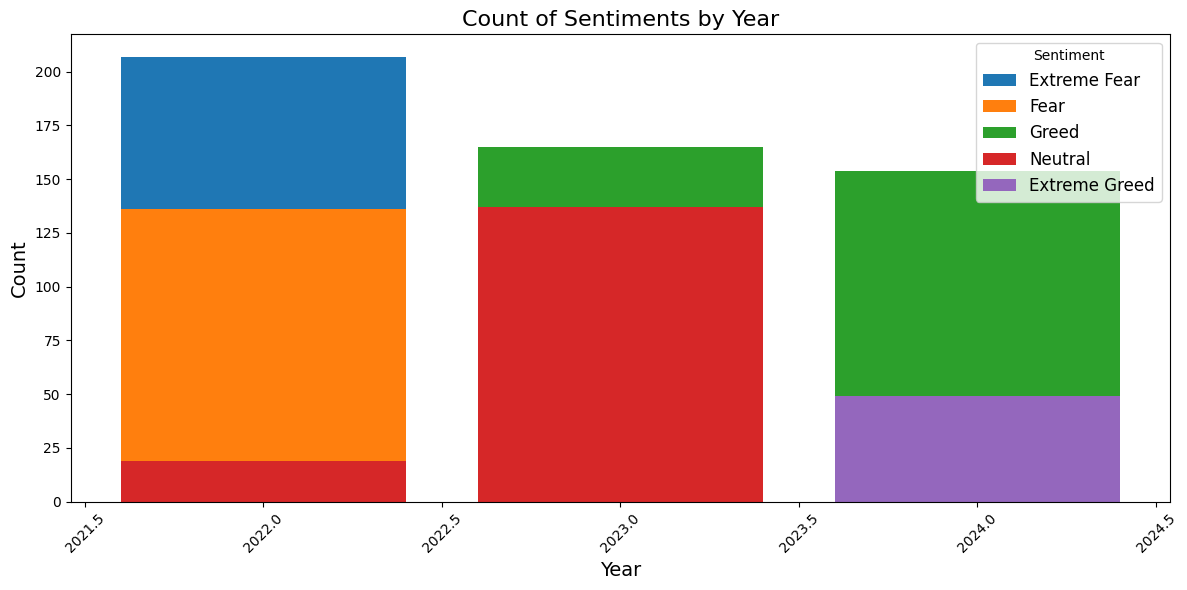

In [260]:
import matplotlib.pyplot as plt

# Sample data for demonstration (replace this with your actual DataFrame)
# yearly_sentiment_counts = pd.DataFrame({
#     'year': [2020, 2020, 2021, 2021],
#     'value_classification': ['Fear', 'Greed', 'Fear', 'Greed'],
#     'count': [10, 15, 20, 25]
# })

# Create a bar plot
plt.figure(figsize=(12, 6))

# Create a bar for each sentiment classification per year
for sentiment in yearly_sentiment_counts['value_classification'].unique():
    subset = yearly_sentiment_counts[yearly_sentiment_counts['value_classification'] == sentiment]
    plt.bar(subset['year'], subset['count'], label=sentiment)

# Add titles and labels
plt.title('Count of Sentiments by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

In [ ]:
# Initialize current max price
current_max_price = 0
# List to store the price ratios
price_ratios = []
max_prices = []

for index, row in bitcoin_df.iterrows():
        daily_avg_price = row['daily_avg_price']

        # Update current max price
        current_max_price = max(current_max_price, daily_avg_price)      
        # Calculate the ratio
        price_ratio = (daily_avg_price - current_max_price) / current_max_price
        max_prices.append(current_max_price)

print(len(bitcoin_df), len(price_ratios), len(max_prices))

2191 0 2191


In [227]:
merged_bitcoin_fg_df[merged_bitcoin_fg_df['date'] == pd.to_datetime('2018-11-24').date()]
# merged_bitcoin_fg_df.dtypes

,date,daily_min_price,daily_max_price,daily_avg_price,current_max_price,price_ratio,MA_30,MA_60,MA_90,MA_120,MA_150,MA_180,MA30_ratio,MA60_ratio,MA90_ratio,MA120_ratio,MA150_ratio,MA180_ratio,value_classification,value
21,2018-11-24,4285.744846,4366.949754,3785.09849,6511.805116,-0.418733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Extreme Fear,15


In [102]:
sell_points = merged_bitcoin_fg_df[
    (merged_bitcoin_fg_df['value_classification'].isin(['Greed', 'Extreme Greed'])) & 
    (merged_bitcoin_fg_df['MA120_ratio'] <= -0.2)
]
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC", sell_points)
fig.show()

In [136]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

In [113]:
merged_bitcoin_fg_df.head()
merged_bitcoin_fg_df.sort_values('date').iloc[-1]['daily_avg_price']

np.float64(62056.4222048493)

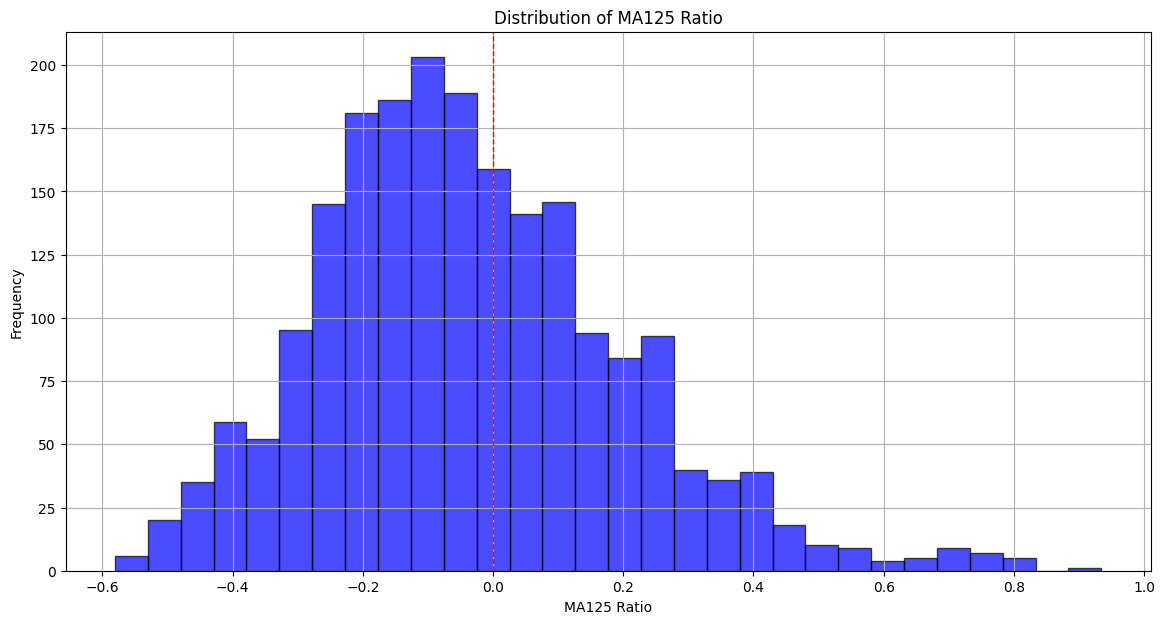

In [61]:
def plot_ma120_ratio_distribution(df):
    plt.figure(figsize=(14, 7))

    # Create a histogram of MA125_ratio
    plt.hist(df['MA120_ratio'].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')

    plt.title('Distribution of MA125 Ratio')
    plt.xlabel('MA125 Ratio')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add a vertical line at x=0 for reference
    plt.grid()
    plt.show()

# Call the function to plot the distribution
plot_ma120_ratio_distribution(merged_bitcoin_fg_df)

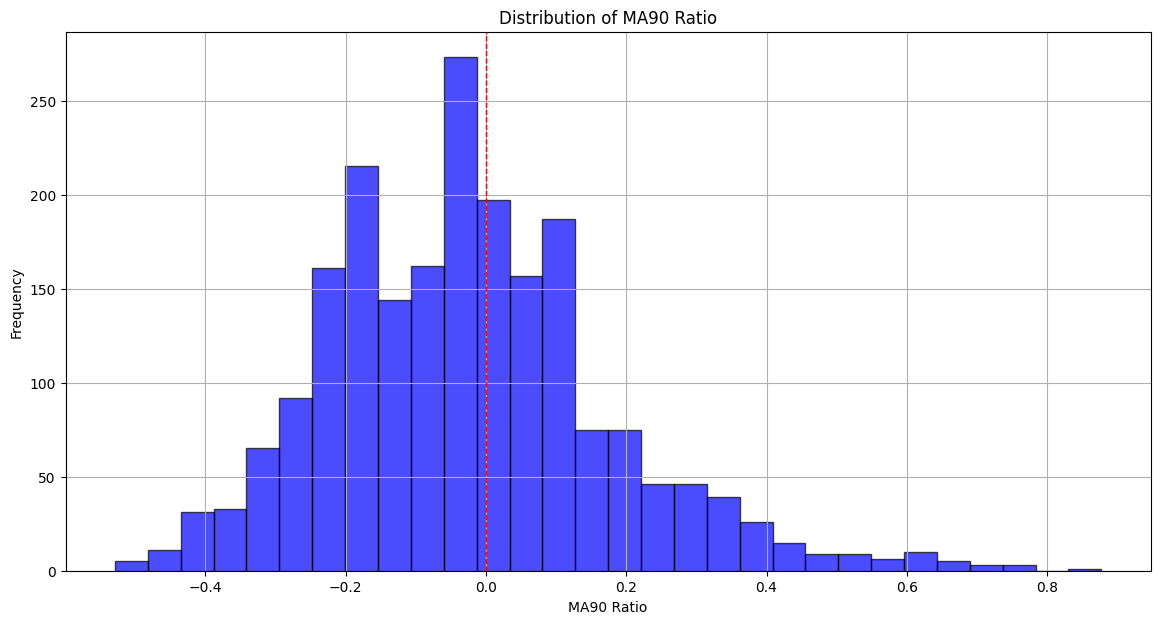

In [135]:
def plot_ma90_ratio_distribution(df):
    plt.figure(figsize=(14, 7))

    # Create a histogram of MA125_ratio
    plt.hist(df['MA90_ratio'].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')

    plt.title('Distribution of MA90 Ratio')
    plt.xlabel('MA90 Ratio')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add a vertical line at x=0 for reference
    plt.grid()
    plt.show()

# Call the function to plot the distribution
plot_ma90_ratio_distribution(merged_bitcoin_fg_df)

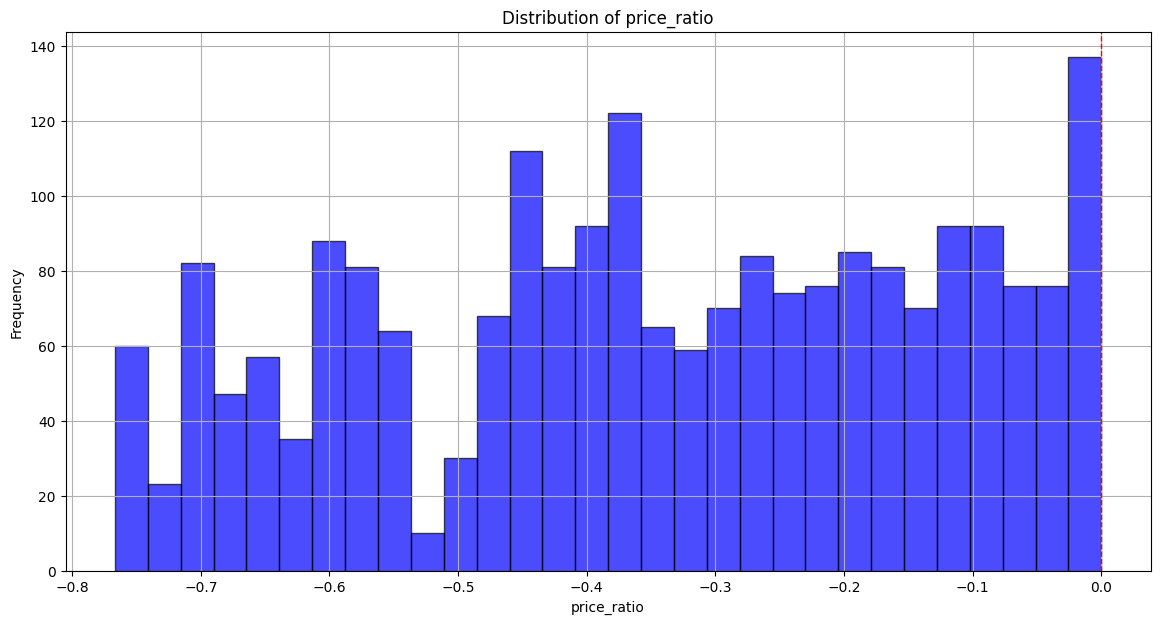

In [190]:
def plot_ma90_ratio_distribution(df):
    plt.figure(figsize=(14, 7))

    # Create a histogram of MA125_ratio
    plt.hist(df['price_ratio'].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')

    plt.title('Distribution of price_ratio')
    plt.xlabel('price_ratio')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add a vertical line at x=0 for reference
    plt.grid()
    plt.show()

# Call the function to plot the distribution
plot_ma90_ratio_distribution(merged_bitcoin_fg_df)

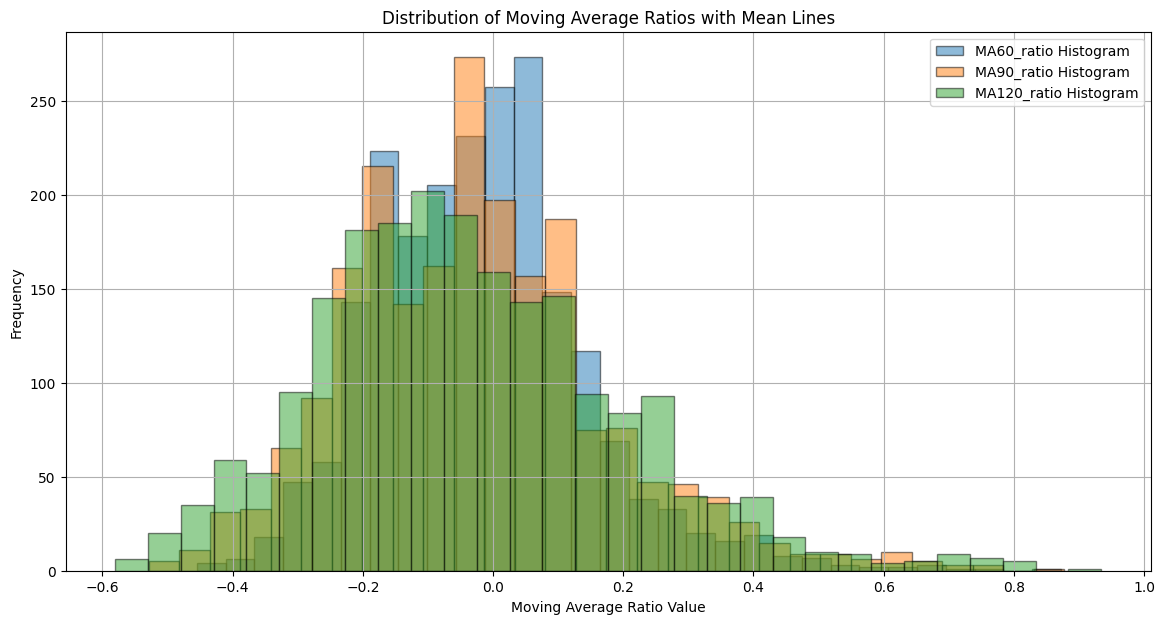

In [673]:
def plot_ma_ratio_distribution_with_lines(df):
    plt.figure(figsize=(14, 7))

    # Create histograms and overlay lines for different moving average ratios
    for ma_ratio in ['MA60_ratio', 'MA90_ratio', 'MA120_ratio']:
        # Create histogram
        plt.hist(df[ma_ratio].dropna(), bins=30, alpha=0.5, label=f'{ma_ratio} Histogram', edgecolor='black')

        # Overlay line for the mean
        mean_value = df[ma_ratio].mean()

    plt.title('Distribution of Moving Average Ratios with Mean Lines')
    plt.xlabel('Moving Average Ratio Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot the distributions
plot_ma_ratio_distribution_with_lines(merged_bitcoin_fg_df)

In [672]:
def plot_ma125_ratio_distribution(df):
    # Calculate mean and standard deviation
    mean_ma125_ratio = df['MA125_ratio'].mean()
    std_ma125_ratio = df['MA125_ratio'].std()
    
    print(f"Mean of MA125 Ratio: {mean_ma125_ratio:.4f}")
    print(f"Standard Deviation of MA125 Ratio: {std_ma125_ratio:.4f}")

    plt.figure(figsize=(14, 7))

    # Create a histogram of MA125_ratio
    plt.hist(df['MA125_ratio'].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')

    plt.title('Distribution of MA125 Ratio')
    plt.xlabel('MA125 Ratio')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add a vertical line at x=0 for reference
    plt.grid()
    plt.show()

# Call the function to plot the distribution
plot_ma125_ratio_distribution(merged_bitcoin_fg_df)

KeyError: 'MA125_ratio'

In [ ]:
Can you create a sniper bot for a wallet and mkae the trade accordingly. here are some resources: API: @https://docs.gmgn.ai/index/cooperation-api-integrate-gmgn-solana-trading-api @https://docs.gmgn.ai/index wallet address for monitor: E5ztgZZeXQmZtw6dubFhvzZMGiEXr4fbh4C6PpzjdjM1
the trading strategy is:
1. monitor the target wallet 24/7
2. when the wallet makes a trade, we make the trade and open our position immediately on if the current coin price is less than 3 times of the average cost of this wallet's open position.
3. keep tracking the coin price, our position, P&L. . if the monitored wallet's position sold all it's position, we close our position immediately as well. if the profit hit 20% and the monitored wallet's position hasn't sold at all, we will close our position 100%.
4. keep monitoring the wallet until it makes the next trade and do the same copy trade.
